# NB4
Now that we finished the returning-to-work piece of the project, let's look at how having more kids affects family income. Sorry in advance, Mom and Dad!

In [1]:
# Set Up
import pandas as pd
import numpy as np

# These lines make warnings look nicer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from IPython.core.display import HTML
from statsmodels.sandbox.regression.gmm import IV2SLS

# Graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,10)
import seaborn as sns

# Specialty Imports

For the IV regression I'm going to be using statsmodels implementation of IV/2-Stage Least Squares. Documentation can be found here https://www.statsmodels.org/stable/generated/statsmodels.sandbox.regression.gmm.IV2SLS.html

# Loading Data

In [2]:
sample = pd.read_csv('sample.csv')


sample3 = pd.DataFrame()

sample3['noHSm'] = [1 if i < 12 else 0 for i in sample['educm']]
sample3['noHSd'] = [1 if i < 12 else 0 for i in sample['educd']]

sample3['agem_squared'] = sample['agem'] ** 2
sample3['agefstm_squared'] = sample['agefstm'] ** 2

sample3['aged_squared'] = sample['aged'] ** 2
sample3['agefstd_squared'] = sample['agefstd'] ** 2

controls = pd.concat([sample3, sample[['educm', 'educd', 'agem', 'aged', 'agefstm', 'agefstd',
                                      'blackm', 'hispm', 'othracem']]], axis = 1)

controls.head()


,noHSm,noHSd,agem_squared,agefstm_squared,aged_squared,agefstd_squared,educm,educd,agem,aged,agefstm,agefstd,blackm,hispm,othracem
0,0,0,729,324,1225,676,12,12,27,35,18,26,0,0,0
1,1,1,900,324,784,289,7,9,30,28,18,17,0,0,0
2,0,0,729,441,900,576,12,13,27,30,21,24,0,0,0
3,0,0,1225,729,1296,841,14,19,35,36,27,29,1,0,0
4,0,0,900,484,1156,676,14,18,30,34,22,26,0,0,0


Let's initialize the summary table that will describes the effect of morekids on 3 dependent variables: 
* a mother's earnings, _earningsm_
* a father's earnings, _earningd_
* family earnings, _famearns_



In [4]:
morekids_effect = pd.DataFrame(index = ["earningsm", "earningsd", "famearn"],
                             columns = ["OLS", "OLS + Controls", "IV", "IV + Controls"])
morekids_effect

,OLS,OLS + Controls,IV,IV + Controls
earningsm,NaN,NaN,NaN,NaN
earningsd,NaN,NaN,NaN,NaN
famearn,NaN,NaN,NaN,NaN


Starting first with the first two columns, we will define a function that saves us time and effort:

In [5]:
def linear_probability_model(features, outcome, intercept = True):
    """Returns the coeffecient of morekids on the outcome variable by running an OLS."""
    
    model = sm.OLS(outcome ,sm.add_constant(features))
    model = model.fit()
    
    return model.params['morekids']

Now running that function 6 times

In [6]:
# Column 1
morekids_effect.loc['earningsm', 'OLS'] = linear_probability_model(sample['morekids'], sample['earningsm'])
morekids_effect.loc['earningsd', 'OLS'] = linear_probability_model(sample['morekids'], sample['earningsd'])
morekids_effect.loc['famearn', 'OLS'] = linear_probability_model(sample['morekids'], sample['famearn'])

# The feature matrix for the second model that has controls in it
features_controls = pd.concat([sample['morekids'], controls],axis = 1)

# Column 2
morekids_effect.loc['earningsm', 'OLS + Controls'] = linear_probability_model(features_controls,sample['earningsm'])
morekids_effect.loc['earningsd', 'OLS + Controls'] = linear_probability_model(features_controls,sample['earningsd'])
morekids_effect.loc['famearn', 'OLS + Controls'] = linear_probability_model(features_controls,sample['famearn'])


morekids_effect

,OLS,OLS + Controls,IV,IV + Controls
earningsm,-3662.02,-4882.46,NaN,NaN
earningsd,-1779.14,-74.1929,NaN,NaN
famearn,-5441.16,-4956.65,NaN,NaN


Overall it seem like having more kids decreases family earnings, but the impact seems to hit the mothers much harder than the fathers. Let's move on to the IV Regression.

# IV 
First and foremost, a helper function.

In [7]:
def IV_2SLS_show_all(dependent, exogenous, instrument):
    """
    Runs the first stag and reduced form models via OLS,
    then runs the 2SLS/IV regression via statsmodels.
    
    Input:
        - dependent: a (nx1) outcome variable
        - exogenous: a (nx1) exogenous variable
        - instrument: a (nx1) instrument to be used for the exogenous variable
    Output:
        prints 3 summary tables of the regression
        1 DataFrame featuring
            - pi: the coeffecient of the first stage
            - delta: the coeffecient of the reduced form
            - ratio: delta/pi
            - iv2sls: coeffecient of the instrument in IV regression
    """

    iv = IV2SLS(dependent, sm.add_constant(exogenous),  sm.add_constant(instrument)).fit()
    return iv.params['morekids']

In [8]:
# Column 3    
morekids_effect.loc['earningsm','IV']= IV_2SLS_show_all(dependent = sample[['earningsm']], 
                                                        exogenous = sample[['morekids']], 
                                                        instrument = sample[['samesex']])

morekids_effect.loc['earningsd','IV']= IV_2SLS_show_all(dependent = sample[['earningsd']], 
                                                        exogenous = sample[['morekids']], 
                                                        instrument = sample[['samesex']])

morekids_effect.loc['famearn','IV']= IV_2SLS_show_all(dependent = sample[['famearn']], 
                                                        exogenous = sample[['morekids']], 
                                                        instrument = sample[['samesex']])


# The feature matrix for the fourth model that has controls in it
instrument_controls = pd.concat([sample['samesex'], controls],axis = 1)

# Column 4 
morekids_effect.loc['earningsm','IV + Controls']= IV_2SLS_show_all(dependent = sample[['earningsm']], 
                                                        exogenous = features_controls, 
                                                        instrument = instrument_controls)

morekids_effect.loc['earningsd','IV + Controls']= IV_2SLS_show_all(dependent = sample[['earningsd']], 
                                                        exogenous = features_controls, 
                                                        instrument = instrument_controls)

morekids_effect.loc['famearn','IV + Controls']= IV_2SLS_show_all(dependent = sample[['famearn']], 
                                                        exogenous = features_controls, 
                                                        instrument = instrument_controls)



morekids_effect

,OLS,OLS + Controls,IV,IV + Controls
earningsm,-3662.02,-4882.46,-3654.25,-3097.66
earningsd,-1779.14,-74.1929,-3155.84,-3596.78
famearn,-5441.16,-4956.65,-6810.09,-6694.44


Observation 1: $\beta_{earningsm}^{IV + Control} > \beta_{earningsm}^{OLS + Control}$
One explanation for why the IV regression predicts that having morekids will be less impactful on your earnings is because your kids being the same sex is determined by random assignment and therefore could be considered an uncorrelated variable with the error term. The OLS model suffers from factors that are still most likely uncontroled for.

Observation 2:  $\beta_{earningsm}^{IV + Control} < \beta_{earningsd}^{OLS + Control}$

Because child bearing is a responsibility imposed on women, it makes sense that father's do not suffer wage losses as large relative to their female counterparts. Also, it is culturally seen in the US (as this is where the data is taken from) that men are more often designated to be bread earners while women are more often the home-maker.

Let's show some results from the fact that $famearn = earningsd + earningsm$

1. The coeffcients follow the same linear relationship

In [6]:
model_1 = sm.OLS(sample[['earningsm']] ,sm.add_constant(sample['morekids']))
model_1 = model_1.fit()

model_2 = sm.OLS(sample[['earningsd']] ,sm.add_constant(sample['morekids']))
model_2 = model_2.fit()

model_3 = sm.OLS(sample[['famearn']] ,sm.add_constant(sample['morekids']))
model_3 = model_3.fit()

display(model_3.params[1],model_1.params[1] + model_2.params[1])

-5441.158425694789

-5441.1584256947535

2. With controls added, the same is true.

In [7]:
model_1c = sm.OLS(sample[['earningsm']] ,sm.add_constant(features_controls))
model_1c = model_1c.fit()

model_2c = sm.OLS(sample[['earningsd']] ,sm.add_constant(features_controls))
model_2c = model_2c.fit()

model_3c = sm.OLS(sample[['famearn']] ,sm.add_constant(features_controls))
model_3c = model_3c.fit()

display(model_3c.params["morekids"],model_1c.params["morekids"] + model_2c.params["morekids"])

-4956.651070957504

-4956.651070957514

3. With this linear relationship in the betas, we can look at the effect of morekids and determine the % contribution given from both mother and father

In [8]:
#Mothers
(morekids_effect["OLS + Controls"][0]/ morekids_effect["OLS + Controls"][2]) * 100

98.50316551421108

In [9]:
#Fathers
(morekids_effect["OLS + Controls"][1]/ morekids_effect["OLS + Controls"][2]) * 100

1.4968344857891172

### Lets now do the same thing with IV 

4. No controls

In [10]:
model_4 = IV2SLS(sample[['earningsm']], sm.add_constant(sample['morekids']),  sm.add_constant(sample['samesex'])).fit()
model_5 = IV2SLS(sample[['earningsd']], sm.add_constant(sample['morekids']),  sm.add_constant(sample['samesex'])).fit()
model_6 = IV2SLS(sample[['famearn']], sm.add_constant(sample['morekids']),  sm.add_constant(sample['samesex'])).fit()

display(model_6.params["morekids"],model_4.params["morekids"] + model_5.params["morekids"])


-6810.08841136237

-6810.088415944501

5. With controls

In [11]:
model_4c = IV2SLS(sample[['earningsm']], sm.add_constant(features_controls),  sm.add_constant(instrument_controls)).fit()
model_5c = IV2SLS(sample[['earningsd']], sm.add_constant(features_controls),  sm.add_constant(instrument_controls)).fit()
model_6c = IV2SLS(sample[['famearn']], sm.add_constant(features_controls),  sm.add_constant(instrument_controls)).fit()

display(model_6c.params["morekids"],model_4c.params["morekids"] + model_5c.params["morekids"])



-6694.435353964713

-6694.4353575998175

6. % Contribution in IV

In [12]:
#Mothers
(morekids_effect["IV + Controls"][0]/ morekids_effect["IV + Controls"][2]) * 100

46.272088748278385

In [13]:
#Fathers
(morekids_effect["IV + Controls"][1]/ morekids_effect["IV + Controls"][2]) * 100

53.727911306022015

After running the IV above we see that the OLS provided some rather biased and extreme results in terms of % determination of the earnings when we look at the respective parent's share over the family earnings. Our IV regression shows that the effect on family income from the decision to have morekids is slightly more driven by the father's decision relative to the mothers. This supports the notion of a father being the "bread-winner" for the family. However, we also noted above that a mother is more likely to suffer a personal loss in income from the decision to have more kids. Reasons for this may because of stigma's against mother's returning to work versus taking care of the children. Pretty cool how social norms are reflected in our analysis!

## Now let's look at the Always Takers, Never Takers, and Compliers within our sample. We are going to assume that there are no defier families.


* Always Takers always have another child
* Compliers are those who have more kids even after have two kids of the same sex
* Never Takers are those who only had at most 2 children

In [14]:
def results(df, treatment_column_name, measured_result):
    control_n = df.groupby([treatment_column_name]).agg('count')['educm'][0]
    treatment_n = df.groupby([treatment_column_name]).agg('count')['educm'][1]
    
    pr_AT = df.groupby([treatment_column_name, measured_result]).agg('count')['KIDCOUNT'][0][1] / control_n 
    pr_NT = 1 - df.groupby([treatment_column_name,measured_result]).agg('count')['KIDCOUNT'][1][1] / treatment_n
    pr_C = df.groupby([treatment_column_name, measured_result]).agg('count')['KIDCOUNT'][1][1] / treatment_n - pr_AT
    
    total = np.sum([pr_AT, pr_NT, pr_C])
    return [pr_AT, pr_NT, pr_C, total]

In [15]:

table = pd.DataFrame(index = ["AT", "NT", "Compliers", "Sum"], 
                     columns = ["sample", "Less than HS Educ", "HS Educ",
                               "Some College", "Bachelors"])
table["sample"] = results(sample, "samesex", "morekids")
table

,sample,Less than HS Educ,HS Educ,Some College,Bachelors
AT,0.339069,NaN,NaN,NaN,NaN
NT,0.593579,NaN,NaN,NaN,NaN
Compliers,0.067352,NaN,NaN,NaN,NaN
Sum,1.000000,NaN,NaN,NaN,NaN


In [16]:
less_hs = sample[sample['educm'] < 12]
hs = sample[sample['educm'] == 12]
some_college = sample[(sample['educm'] > 12) & (sample['educm'] <= 15)]
bachelor = sample[sample['educm'] == 12]

In [17]:
table["sample"] = results(sample, "samesex", "morekids")
table["Less than HS Educ"] = results(less_hs, "samesex", "morekids")
table["HS Educ"] = results(hs, "samesex", "morekids")
table["Some College"] = results(some_college, "samesex", "morekids")
table["Bachelors"] = results(bachelor, "samesex", "morekids")

table

,sample,Less than HS Educ,HS Educ,Some College,Bachelors
AT,0.339069,0.468634,0.325621,0.309460,0.325621
NT,0.593579,0.459558,0.602934,0.619832,0.602934
Compliers,0.067352,0.071808,0.071445,0.070708,0.071445
Sum,1.000000,1.000000,1.000000,1.000000,1.000000


Let's visualize these tables by scaling the y-axis to be the probability scale and then looking at fractions by  education level and by what type of individual (AT,NT,Compliers) they were.

(0, 1)

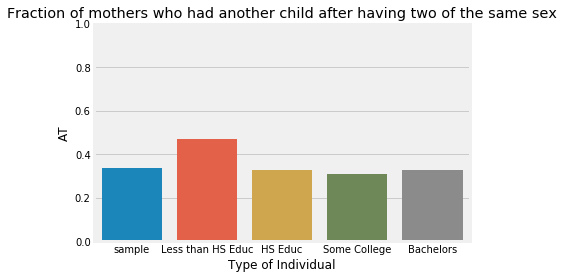

In [33]:
sns.barplot(data = table.T, y = ('AT'), x = table.T.index)
plt.title('Fraction of mothers who had another child after having two of the same sex')
plt.xlabel('Type of Individual')
plt.ylim(0,1);

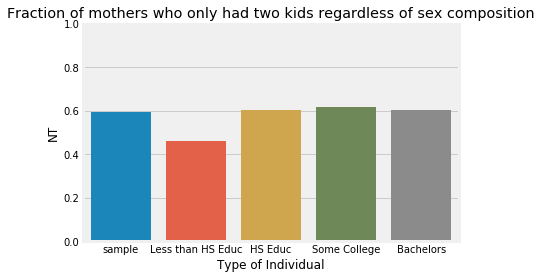

In [34]:
sns.barplot(data = table.T, y = ('NT'), x = table.T.index)
plt.title('Fraction of mothers who only had two kids regardless of sex composition')
plt.xlabel('Type of Individual')
plt.ylim(0,1);

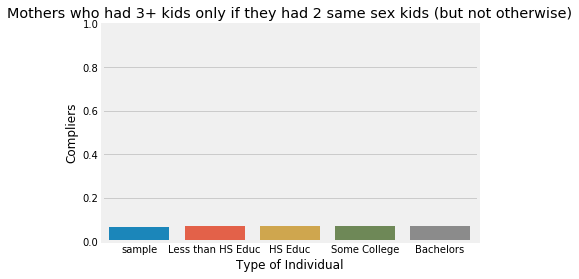

In [64]:
sns.barplot(data = table.T, y = ('Compliers'), x = table.T.index)
plt.title('Mothers who had 3+ kids only if they had 2 same sex kids (but not otherwise)')
plt.xlabel('Type of Individual')
plt.ylim(0,1);

The Always Takers, moms who "went for one more child" seem to be those that were less educated. This is a good reason to investigate the racial composition of that subgroup because perhaps international culture may urge parents to have both female and male children, especially in the case of a male heir.

Never takers seems to be more common for those who are higher educated as the bars in the second graph are higher than that in the first.

The compliers groups seems to be very small and not have much variation across education. Let's look at the differences between the compliers a bit further. We can begin observing that a complier in this case would be a 
* parent who has had 3+ kids, where they did have two kids with the same sex but the first baby's gender was not indicative of the following 2

* Ex: Aunt Sally had 1 boy, then 1 girl (boy1st == 1, girls2 = 0), then had a child that chose their gender regardless of their sex.

In [108]:
compliers = sample[(sample['morekids'] == 1) 
                   & (sample['samesex'] == 1) 
                   & (sample['girls2'] == 0) 
                   & (sample['boy1st'] == 1)]

n = len(compliers)

less_hs_compliers = len(compliers[compliers['educm'] < 12])/n
black_compliers = len(compliers[compliers['blackm'] == 1])/n
white_nh_compliers = len(compliers[compliers['wnhm'] == 1])/n
hispanic_compliers = len(compliers[compliers['hispm'] == 1])/n
utah_compliers = len(compliers[compliers['st'] == 87])/n

race_stats = [less_hs_compliers,
black_compliers,
white_nh_compliers,
hispanic_compliers,
utah_compliers]


mean_stats= [np.mean(compliers['educm']), np.mean(compliers['agem']), np.mean(compliers['agefstm'])]

complier_race = pd.DataFrame(index = ["Fraction of Under HS Educ",
                                        "Fraction of Black Compliers",
                                        "Fraction of White Non Hispanic Compliers",
                                        "Fraction of Hispanic",
                                        "Fraction of Compliers in Utah"],
                             columns = ['Value'])
                             
                             
complier_mean = pd.DataFrame(index = ["Mean Educ of Mother Compliers",
                                        "Mean Age of Mother Compliers",
                                        "Mean Age of First Time Mother Compliers"],
                               columns = ['Value'])

complier_race['Value'] = race_stats


complier_mean['Value'] = mean_stats


In [126]:
complier_race

,Value
Fraction of Under HS Educ,0.225357
Fraction of Black Compliers,0.057910
Fraction of White Non Hispanic Compliers,0.879537
Fraction of Hispanic,0.035178
Fraction of Compliers in Utah,0.018330


In [127]:
complier_mean

,Value
Mean Educ of Mother Compliers,12.044823
Mean Age of Mother Compliers,30.808020
Mean Age of First Time Mother Compliers,20.211030


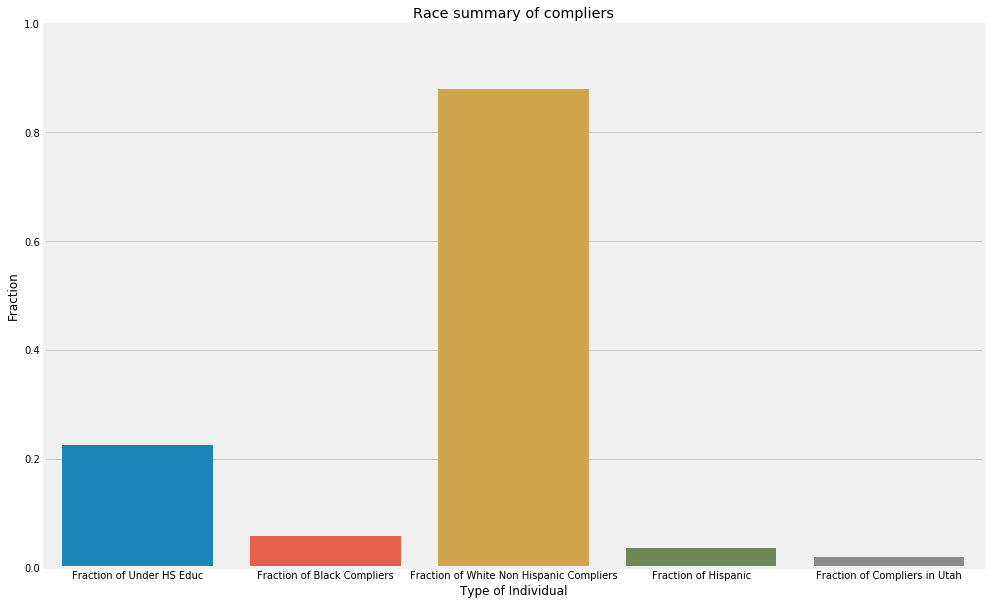

In [125]:
plt.figure(figsize=(15,10))
chart = sns.barplot(data = complier_race, y = ('Value'), x = complier_race.index)
plt.title('Race summary of compliers')
plt.xlabel('Type of Individual')
#chart.set_xticklabels(chart.get_xticklabels(), rotation=25)
plt.ylabel('Fraction')
plt.ylim(0,1);

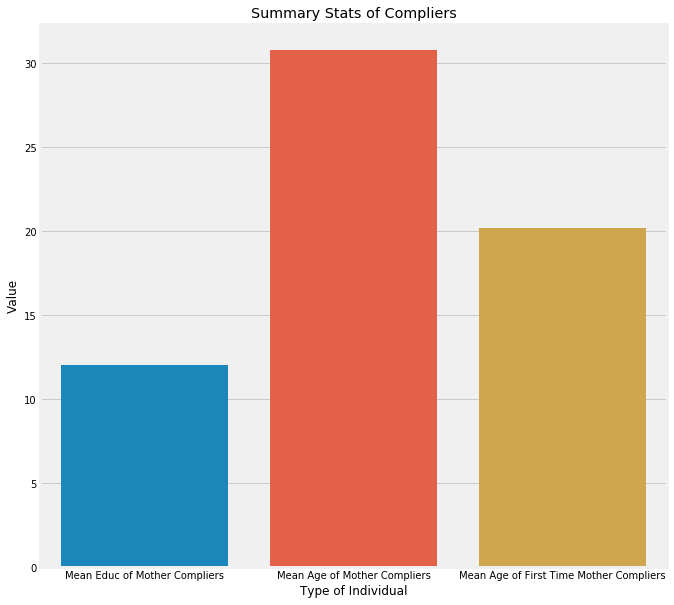

In [118]:
plt.figure(figsize=(10,10))
chart = sns.barplot(data = complier_mean, y = ('Value'), x = complier_mean.index)
plt.title('Summary Stats of Compliers')
plt.xlabel('Type of Individual');

From this we can see that compliers are on average identifying as white, non-hispanic mothers who are in their early thirties, and about a high school level of education. In order to be a complier, mothers have to have 3 kids hence it makes sense that most of them are first time mothers on average by 20. 

The Utah statistic is quite interesting. Utah is historically Mormon, which is a religion statistically tied to having more children, is influencing the young, complier mother category we are discovering.